# House price prediction

This notebook his my personal take on the kaggle competition "House Prices: Advanced Regression Techniques" (see: https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

I would like to give credit to the following Kaggle users who helped me by sharing their work:

- Goldens https://www.kaggle.com/goldens/house-prices-on-the-top-with-a-simple-model
- Pedro Marcelino https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

and more generally, the Kaggle community by sharing their thoughts and advice on the forum.

## My approach to this problem

My approach is pretty straight-forward, a little bit of data cleansing and then modelling with the off-the-shelf models I know.

In [40]:
# The packages used in this notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Two personal functions used in the notebook

def mapToOrd(df, cols, mapping):
    return(df[cols].apply(lambda x: x.map(mapping)))

def rootMSE(model, X, y_true):
    y_pred = model.predict(X)
    return(np.sqrt(((y_pred-y_true)**2).mean()))

## Data preparation

This part consist mostly in:

- finding an deleting outliers;
- finding and replacing missing values;
- transforming highly skewed data to normalize them;
- using one-hot encoding for categorical data;
- Scale data.

When replacing missing values, we will keep the training and testing data set seprated to avoid data leakage.

In [41]:
# Loading data, keeping training and testing separated

train = pd.read_csv('train.csv', header = 0)
test = pd.read_csv('test.csv', header = 0)
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

# Setting the dependant variable
target = 'SalePrice'

# MSSubClass and YrSold are encoded as integer-valued varaibles but they are categorical variables
cols = ['MSSubClass', 'YrSold']
train[cols] = train[cols].astype('object')
test[cols] = test[cols].astype('object')

# Find categorial and numerical values
categorical = train.select_dtypes(include=['object']).columns
numerical = train.select_dtypes(include=['int64','float64']).columns

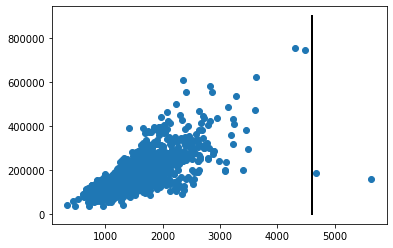

In [42]:
# Below chart will highlight some outliers for the variable GrLivArea in the training data

plt.scatter(train['GrLivArea'], train[target])
plt.plot([4600, 4600], [0, 900000], 'k-', lw=2)

In [43]:
# Drop outliers for 'GrLivArea'

train = train.drop(train[train['GrLivArea']>4600].index)

# Inspect missing numerical values

print('For train \n', train[numerical].isnull().sum()[train[numerical].isnull().sum()>0],
      '\n For test \n', test[numerical.drop(target)].isnull().sum()[test[numerical.drop(target)].isnull().sum()>0])

For train 
 LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64 
 For test 
 LotFrontage     227
MasVnrArea       15
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt      78
GarageCars        1
GarageArea        1
dtype: int64


In [44]:
# For some variables, NA indicates the absence of the variable (e.g. no garage), those will be replaced by 0
numto0 = ['GarageYrBlt', 'GarageCars', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
         'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

train[numto0] = train[numto0].fillna(value=0)
test[numto0] = test[numto0].fillna(value=0)

# For lot frontage we will replace by the mean
numtoMean = ['LotFrontage']

train[numtoMean] = train[numtoMean].fillna(value=train[numtoMean].mean())
test[numtoMean] = test[numtoMean].fillna(value=test[numtoMean].mean())

#Inspect missing categorial values

print('For train \n', train[categorical].isnull().sum()[train[categorical].isnull().sum()>0],
      '\n For test \n', test[categorical].isnull().sum()[test[categorical].isnull().sum()>0])

For train 
 Alley           1367
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1452
Fence           1177
MiscFeature     1404
dtype: int64 
 For test 
 MSZoning           4
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageFinish      78
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64


In [45]:
# For some variables, NA indicates the absence of the variable (e.g. no garage), those will be replaced by None
catwNA = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
          'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'Functional']

train[catwNA] = train[catwNA].fillna(value='None')
test[catwNA] = test[catwNA].fillna(value='None')

# For the other we will replace NA by the most frequent value (the mode), this only concern the test set
catwoNA = list(set(test[categorical].isnull().sum()[test[categorical].isnull().sum()>0].index)-set(catwNA))

test[catwoNA] = test[catwoNA].apply(lambda x: x.fillna(value=x.mode()[0]))

# Sanity check, two empty series are expected

print('For train \n', train.isnull().sum()[train.isnull().sum()>0],
      '\n For test \n', test.isnull().sum()[test.isnull().sum()>0])

For train 
 Series([], dtype: int64) 
 For test 
 Series([], dtype: int64)


## Converting ordinal data (optional)

Ordinal data are encoded as categorical. To preserve the order of the data we can convert the labels to integer. Since doing this do not gives good result when testing the models, this part of the notebook is entirely commented.

In [46]:
# order1 = {'Ex' : 4, 'Gd' : 3, 'TA' : 2, 'Fa' : 1, 'Po' : 1, 'None': 0}
# catToOrd1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 
#              'GarageCond', 'PoolQC']

# order2 = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
# catToOrd2 = ['BsmtExposure']

# order3 = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'None':0}
# catToOrd3 = ['BsmtFinType1', 'BsmtFinType2']

# order4 = {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1, 'None': 0}
# catToOrd4 = ['Functional']

# order5 = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
# catToOrd5 = ['GarageFinish']

# order6 = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0}
# catToOrd6 = ['Fence']

# for i in range(1,7):
#     train[globals()['catToOrd'+str(i)]] = mapToOrd(train, globals()['catToOrd'+str(i)], globals()['order'+str(i)])
#     test[globals()['catToOrd'+str(i)]] = mapToOrd(test, globals()['catToOrd'+str(i)], globals()['order'+str(i)])

## Data transformation

Now that missing values are replaced we need to:

- transform skewed data (log-transformation);
- apply one-hot encoding (a.k.a. dummy encoding).

For the encoding, training and testing data sets must be concatenated in one dataframe. This concatenation will also be convenient for the log-transformation.

In [47]:
# Prepare X and y for future model training
X = train.drop(target, axis=1)
y = train[target]

# the len of the training data set must be stored to de-concatenate
len_X = X.shape[0]

# Concatenation
data = pd.concat([X,test], sort=False)

# Find highly skewed features and apply log transformation
skewed_feats = data[numerical.drop(target)].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.8]
skewed_feats = skewed_feats.index
data[skewed_feats] = np.log1p(data[skewed_feats])

# Apply log-transformation to the target
y = np.log1p(y)

# Get dummies
data = pd.get_dummies(data)

# Retrieve train and test
X = data[:len_X]
test = data[len_X:]

# Scale data
scaler = RobustScaler()
X = scaler.fit_transform(X)
test = scaler.transform(test)

## Train test split on the training dataset

In order to test the generalization ability of our model, we use the standard train_test_split function to keep a portion of the training data (i.e. the data for which the sale price is known) as testing data.

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Testing models

In this part we will train and compare several models on the test data set. The cost function is the root mean log squarred error (which is the root mean square error between the log prediction and the log true price). Since we used a log transformation for the target variable this metric is very convenient (considering that we only manipulate log-values we will refer to the root mean log squared error as "mean rmse").

## Cross-validation

When relevant, we will use cross-validation to tune the hyperparameter of the model.

In [12]:
# First, Lasso regression

lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005, 0.0001], max_iter=10000, cv=10).fit(X_train, y_train)

print('alpha chosen: ', lasso.alpha_)
print('rmse training training for chosen alpha: ', 
      np.sqrt(-cross_val_score(lasso, X_train, y_train, scoring="neg_mean_squared_error", cv = 5)).min())
print('rmse testing: ', np.sqrt(mean_squared_error(lasso.predict(X_test), y_test)))

# The lasso regression perform nicely with good generalization ability.

alpha chosen :  0.0005
Mean rmse training for chosen alpha:  0.08897986271017874
Mean rmse testing:  0.10720333225837815


In [13]:
#Second, Ridge regression

ridge = RidgeCV(alphas = [1, 0.1, 0.001, 0.0005, 0.0001], cv=10).fit(X_train, y_train)

print('alpha chosen : ', ridge.alpha_)
print('rmse training for chosen alpha: ', np.sqrt(-cross_val_score(ridge, X, y, scoring="neg_mean_squared_error", cv = 5)).min())
print('rmse testing: ', np.sqrt(mean_squared_error(ridge.predict(X_test), y_test)))

 # The Ridge regression is also suitable but a little bit less than the lasso.

alpha chosen :  1.0
Mean rmse training for chosen alpha:  0.10607143225259545
Mean rmse score testing :  0.11755501159922621


In [32]:
# Third, Random forest regression

RFR = RandomForestRegressor()
parameters = {'min_samples_leaf': [1, 5, 10, 20]}
gridRFR = GridSearchCV(RFR, parameters, scoring = rootMSE, cv = 5).fit(X_train, y_train)

print('Best parameter: ', gridRFR.best_params_)
print('rmse training: ', gridRFR.cv_results_['mean_test_score'])
print('rmse testing: ', np.sqrt(mean_squared_error(gridRFR.predict(X_test), y_test)))

# Random forest regression performs poorly compared to lasso

Min samples leaf chose:  {'min_samples_leaf': 20}
Mean rmse training:  [0.14093463 0.14433357 0.15248714 0.16799692]
Mean rmse testing:  0.15948276654275553


In [15]:
# Fourth, gradient boosting

parameters = {'min_samples_leaf': [1, 5, 10, 20]}

GBR = GradientBoostingRegressor(n_estimators=100, max_depth=3)
gridGBR = GridSearchCV(GBR, parameters, scoring = rootMSE, cv = 5).fit(X_train, y_train)

print('Best parameter: ', gridGBR.best_params_)
print('rmse training for chosen paramater: ', gridGBR.cv_results_['mean_test_score'])
print('Mean rmse testing : ', np.sqrt(mean_squared_error(gridGBR.predict(X_test), y_test)))

# Gradient boosting performance are average

Mean rmse :  [0.12567065 0.12402143 0.12754673 0.12962721]
Mean rmse testing :  0.1264489787199797


In [18]:
# Fifth support vector regressor

parameters = {'C': [1, 0.5, 0.1, 0.001, 0.0005]}

SVregr = SVR(kernel='linear')
gridSVR = GridSearchCV(SVregr, parameters, scoring = rootMSE, cv = 5).fit(X_train, y_train)

print('Best parameter: ', gridSVR.best_params_)
print('rmse training for chosen parameter: ', gridSVR.cv_results_['mean_test_score'])
print('rmse testing : ', np.sqrt(mean_squared_error(gridSVR.predict(X_test), y_test)))

# SVR performance are average

Mean rmse :  [0.13421237 0.12958431 0.11973102 0.12858176 0.14165405]
Mean rmse testing :  0.12598714976796632


In [27]:
# Sixth, elasctinet

elasti = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1] ,alphas = [1, 0.1, 0.001, 0.0005, 0.0001], 
                max_iter=10000, cv=5).fit(X_train, y_train)

print('alpha chosen: ', elasti.alpha_)
print('l1 chosen: ', elasti.l1_ratio_)
print('rmse training for chosen paramaters: ', np.sqrt(-cross_val_score(elasti, X_train, y_train, 
                                                   scoring="neg_mean_squared_error", cv = 5)).min())
print('rmse testing: ', np.sqrt(mean_squared_error(elasti.predict(X_test), y_test)))

# Elasticnet model offers performance comparable to a Lasso model

Best mean rmse training :  0.08947037410868156
alpha chosen :  0.0005
l1 chosen :  0.7
Mean rmse testing :  0.10773692014910224


In [30]:
# Seventh, MLP

grid_act = {'activation': ['identity', 'logistic', 'tanh', 'relu']}

MLP = MLPRegressor(hidden_layer_sizes=(100,50,50,50))

grid_MLP = GridSearchCV(MLP, grid_act, scoring = rootMSE, cv = 5).fit(X_train, y_train)

print('rmse training: ', grid_MLP.cv_results_['mean_test_score'])
print('Mean rmse testing: ', np.sqrt(mean_squared_error(grid_MLP.predict(X_test), y_test)))

# Multi-layer perceptron performs quite poorly!

rmse training :  [0.20704412 0.40588016 0.30128559 0.41418056]
Mean rmse testing :  0.32841281596205507


## Stacking regressor

All the models above (except the MLP which performs so poorly) will be stacked in one big regressor. The choice of the final (or meta) estimator will be done by comparing several results.

In [31]:
# Eigth, stacked

estimators = [('ridge', Ridge(alpha=1., max_iter=10000)), ('lasso', Lasso(alpha=0.0005, max_iter=100000)),
             ('elasti', ElasticNet(l1_ratio = 0.7, alpha=0.0005, max_iter=100000))]

# The code below was used to compare several meta-estimator with several paramters. 
# Since it takes quite long to compute, it has been commented.

# for final_estimator in ['Ridge', 'Lasso']:
#     print(final_estimator)
#     for alpha in [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]:
#         if(final_est == 'Ridge'):
#             reg = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha = alpha)).fit(X_train, y_train)
#             print('Mean rmse score testing for ', alpha,' = ', np.sqrt(mean_squared_error(reg.predict(X_test), y_test)))
#         else:
#             reg = StackingRegressor(estimators=estimators, final_estimator=Lasso(alpha = alpha)).fit(X_train, y_train)
#             print('Mean rmse score testing for ', alpha,' = ', np.sqrt(mean_squared_error(reg.predict(X_test), y_test)))
# double loop above give the best rmse testing for lasso with alpha = 0.001

# for alpha in [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]:
#     for l1_ratio in [.1, .5, .7, .9, .95, .99, 1]:
#         reg = StackingRegressor(estimators=estimators, 
#                                 final_estimator=ElasticNet(alpha = alpha, l1_ratio = l1_ratio)).fit(X_train, y_train)
#         print('Mean rmse score testing for ', alpha, ' ', l1_ratio, ' = ', 
#               np.sqrt(mean_squared_error(reg.predict(X_test), y_test)))

# double loop above give the best rmse testing for alpha = 0.0005 l1_ratio = 0.9

In [36]:
# Finally we compare two choices of meta-estimator with the best estimation for the hyper-paramaters.

reg1 = StackingRegressor(estimators=estimators, final_estimator=Lasso(alpha = 0.001, max_iter=100000)).fit(X_train, y_train)
reg2 = StackingRegressor(estimators=estimators, 
                         final_estimator=ElasticNet(alpha = 0.0005, l1_ratio = 0.9, max_iter=100000)).fit(X_train, y_train)
print('rmse testing for Lasso: ', np.sqrt(mean_squared_error(reg1.predict(X_test), y_test)))
print('rmse testing for Elastic:', np.sqrt(mean_squared_error(reg2.predict(X_test), y_test)))

# Lasso is found to perform slighly better. Nonetheless, stacking regressor do not improve the performance on the test set.
# The pertinence of using such a technique is therefore disputed for this example.

rmse score testing for Lasso:  0.10768773658560624
rmse score testing for Elastic: 0.1079094748994152


## Final estimation

Now that we found the best pick for the final estimator we will just train it on the full training data.
We should not forget to inverse the transformation applied on the sale price, i.e. exponentiate it.

In [38]:
# Model 1 : lasso

model = LassoCV(alphas = [1, 0.1, 0.001, 0.0005, 0.0001], max_iter=10000, cv=10).fit(X, y)

print('alpha chosen : ', model.alpha_) 
print('rmse for alpha chosen: ', np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5)).min())

# Prediction with the model
res = np.expm1(model.predict(test))
pd.DataFrame(res, index=list(range(1461,2920)), columns=['SalePrice']).to_csv("mypred.csv", index_label='Id')

# The chosen alpha is consistent with the one found during testing.
# Those predictions scored 0.11904, in the top 21% as of 07/02/2020

alpha chosen :  0.0005
rmse for alpha chosen:  0.10217841713497391


In [39]:
# Model 2 : stacked regressors

estimators = [('ridge', Ridge(alpha=1.)), ('lasso', Lasso(alpha=0.0005, max_iter=10000)), ('forest', RandomForestRegressor()),
             ('gradient', GradientBoostingRegressor(min_samples_leaf=10)), ('SVR', SVR(kernel='linear', C=0.1)),
             ('elasti', ElasticNet(l1_ratio = 0.7, alpha=0.0005, max_iter=10000))]

stack = StackingRegressor(estimators=estimators, 
                         final_estimator=Lasso(alpha = 0.001, max_iter=100000)).fit(X, y)

print('Mean mse score : ', np.sqrt(mean_squared_error(stack.predict(X), y)))

res = np.expm1(stack.predict(test))
pd.DataFrame(res, index=list(range(1461,2920)), columns=['SalePrice']).to_csv("mypred_Stacked.csv", index_label='Id')

# Those predictions scored 0.11860, in the top 20% as of 07/02/2020

Mean mse score :  0.09161238782968201


## Conclusion

By stacking regressors we were able to reach a decent rmse on 50% of the log-price of the test set. 
We still do not explain why stacking performance were lower than simple lasso while testing.